In [1]:
import os
import numpy as np
import threading as thr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
mammo_o, mammo_f, label = [], [], []
data_folder = "../dataset/"
os.chdir(data_folder)
l = os.listdir()

In [4]:
def create_dataset(lista, o_img, f_img, labels):
    #Function calling the Matlab file in order to filter the images.
    for element in lista:
        if "_1_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(1)
        elif "_2_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(0)

In [5]:
os.chdir("./")
threads = []
chunk = 6

for i in range(49):
    t = thr.Thread(target = create_dataset, args = (l[i*chunk : (i+1)*chunk], mammo_o, mammo_f, label))
    threads.append(t)
    t.start()
    
for j in threads:
    j.join()

In [6]:
mammo_o = np.asarray(mammo_o, dtype = 'float32')/255.
mammo_f = np.asarray(mammo_f, dtype = 'float32')/255.
label = np.asarray(label)
mammo_o_4d = np.reshape(mammo_o, (147, 125, 125, 1))
print(mammo_o_4d.shape)
mammo_f_4d = np.reshape(mammo_f, (147, 64, 64, 1))
print(mammo_f_4d.shape)

(147, 125, 125, 1)
(147, 64, 64, 1)


In [7]:
def cnn_o(shape=(125, 125, 1)):
    model = Sequential([
        
        Conv2D(4, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.1),
        
        
        Conv2D(8, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(10, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.2),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [8]:
model_o = cnn_o()
model_o.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 4)       40        
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 4)      16        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 4)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 8)         2

In [9]:
learning_rate = 0.001
model_o.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [11]:
X_train_o, X_val_o, Y_train_o, Y_val_o = train_test_split(mammo_o_4d, label, test_size = 0.2, random_state = 44)
batch_size = 21
train_o = model_o.fit(X_train_o, Y_train_o,
                     batch_size = batch_size,
                     epochs = 260, 
                     verbose = 1,
                     validation_data = (X_val_o, Y_val_o),
                     callbacks = [reduce_on_plateau])    

Epoch 1/260
6/6 [==============================] - 9s 677ms/step - loss: 0.6641 - accuracy: 0.5897 - val_loss: 0.6905 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 2s 386ms/step - loss: 0.6438 - accuracy: 0.6496 - val_loss: 0.6879 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 2s 388ms/step - loss: 0.6447 - accuracy: 0.6239 - val_loss: 0.6876 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 2s 372ms/step - loss: 0.5986 - accuracy: 0.6581 - val_loss: 0.6866 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 2s 349ms/step - loss: 0.6206 - accuracy: 0.6410 - val_loss: 0.6843 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 2s 359ms/step - loss: 0.5775 - accuracy: 0.6923 - val_loss: 0.6825 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 7/260
6/6 [==============================] - 2s 382ms/step - loss: 0.5

Epoch 53/260
6/6 [==============================] - 2s 349ms/step - loss: 0.5446 - accuracy: 0.6752 - val_loss: 0.6739 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 54/260
6/6 [==============================] - 2s 365ms/step - loss: 0.5417 - accuracy: 0.7265 - val_loss: 0.6735 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 55/260
6/6 [==============================] - 2s 347ms/step - loss: 0.5334 - accuracy: 0.7265 - val_loss: 0.6732 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 56/260
6/6 [==============================] - 2s 347ms/step - loss: 0.5712 - accuracy: 0.7009 - val_loss: 0.6728 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 57/260
6/6 [==============================] - 2s 357ms/step - loss: 0.5406 - accuracy: 0.7436 - val_loss: 0.6724 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 58/260
6/6 [==============================] - 2s 357ms/step - loss: 0.5481 - accuracy: 0.7436 - val_loss: 0.6717 - val_accuracy: 0.6000 - lr: 1.0000e-06
Epoch 59/260
6/6 [============================

6/6 [==============================] - 2s 371ms/step - loss: 0.5771 - accuracy: 0.7179 - val_loss: 0.6619 - val_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 105/260
6/6 [==============================] - 2s 369ms/step - loss: 0.5601 - accuracy: 0.7350 - val_loss: 0.6621 - val_accuracy: 0.6000 - lr: 1.0000e-08
Epoch 106/260
6/6 [==============================] - 2s 358ms/step - loss: 0.5362 - accuracy: 0.7009 - val_loss: 0.6623 - val_accuracy: 0.6000 - lr: 1.0000e-08
Epoch 107/260
6/6 [==============================] - 2s 352ms/step - loss: 0.5390 - accuracy: 0.7179 - val_loss: 0.6626 - val_accuracy: 0.6000 - lr: 1.0000e-08
Epoch 108/260
6/6 [==============================] - 2s 356ms/step - loss: 0.5497 - accuracy: 0.6838 - val_loss: 0.6628 - val_accuracy: 0.6000 - lr: 1.0000e-08
Epoch 109/260
6/6 [==============================] - 2s 379ms/step - loss: 0.5411 - accuracy: 0.7179 - val_loss: 0.6630 - val_accuracy: 0.6000 - lr: 1.0000e-08
Epoch 110/260
6/6 [==============================] - 2

6/6 [==============================] - 2s 378ms/step - loss: 0.5528 - accuracy: 0.6923 - val_loss: 0.6687 - val_accuracy: 0.5667 - lr: 1.0000e-13
Epoch 156/260
6/6 [==============================] - 2s 398ms/step - loss: 0.5492 - accuracy: 0.7436 - val_loss: 0.6687 - val_accuracy: 0.5667 - lr: 1.0000e-13
Epoch 157/260
6/6 [==============================] - 2s 376ms/step - loss: 0.5635 - accuracy: 0.6838 - val_loss: 0.6687 - val_accuracy: 0.5667 - lr: 1.0000e-13
Epoch 158/260
6/6 [==============================] - 2s 364ms/step - loss: 0.5309 - accuracy: 0.7265 - val_loss: 0.6688 - val_accuracy: 0.5667 - lr: 1.0000e-13
Epoch 159/260
6/6 [==============================] - 2s 388ms/step - loss: 0.5515 - accuracy: 0.7179 - val_loss: 0.6688 - val_accuracy: 0.5667 - lr: 1.0000e-13
Epoch 160/260
6/6 [==============================] - 2s 349ms/step - loss: 0.5565 - accuracy: 0.6923 - val_loss: 0.6688 - val_accuracy: 0.5667 - lr: 1.0000e-13
Epoch 161/260
6/6 [==============================] - 2

6/6 [==============================] - 1s 218ms/step - loss: 0.5306 - accuracy: 0.7265 - val_loss: 0.6692 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 207/260
6/6 [==============================] - 1s 218ms/step - loss: 0.5564 - accuracy: 0.7094 - val_loss: 0.6692 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 208/260
6/6 [==============================] - 1s 218ms/step - loss: 0.5626 - accuracy: 0.6923 - val_loss: 0.6692 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 209/260
6/6 [==============================] - 1s 214ms/step - loss: 0.5625 - accuracy: 0.7094 - val_loss: 0.6692 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 210/260
6/6 [==============================] - 1s 221ms/step - loss: 0.5668 - accuracy: 0.6923 - val_loss: 0.6692 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 211/260
6/6 [==============================] - 1s 221ms/step - loss: 0.5383 - accuracy: 0.7094 - val_loss: 0.6692 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 212/260
6/6 [==============================] - 1

6/6 [==============================] - 2s 262ms/step - loss: 0.5447 - accuracy: 0.7009 - val_loss: 0.6693 - val_accuracy: 0.5667 - lr: 1.0000e-23
Epoch 258/260
6/6 [==============================] - 2s 270ms/step - loss: 0.5432 - accuracy: 0.7009 - val_loss: 0.6692 - val_accuracy: 0.5667 - lr: 1.0000e-23
Epoch 259/260
6/6 [==============================] - 2s 257ms/step - loss: 0.5443 - accuracy: 0.7009 - val_loss: 0.6693 - val_accuracy: 0.5667 - lr: 1.0000e-23
Epoch 260/260
6/6 [==============================] - 1s 247ms/step - loss: 0.5665 - accuracy: 0.6838 - val_loss: 0.6692 - val_accuracy: 0.5667 - lr: 1.0000e-23


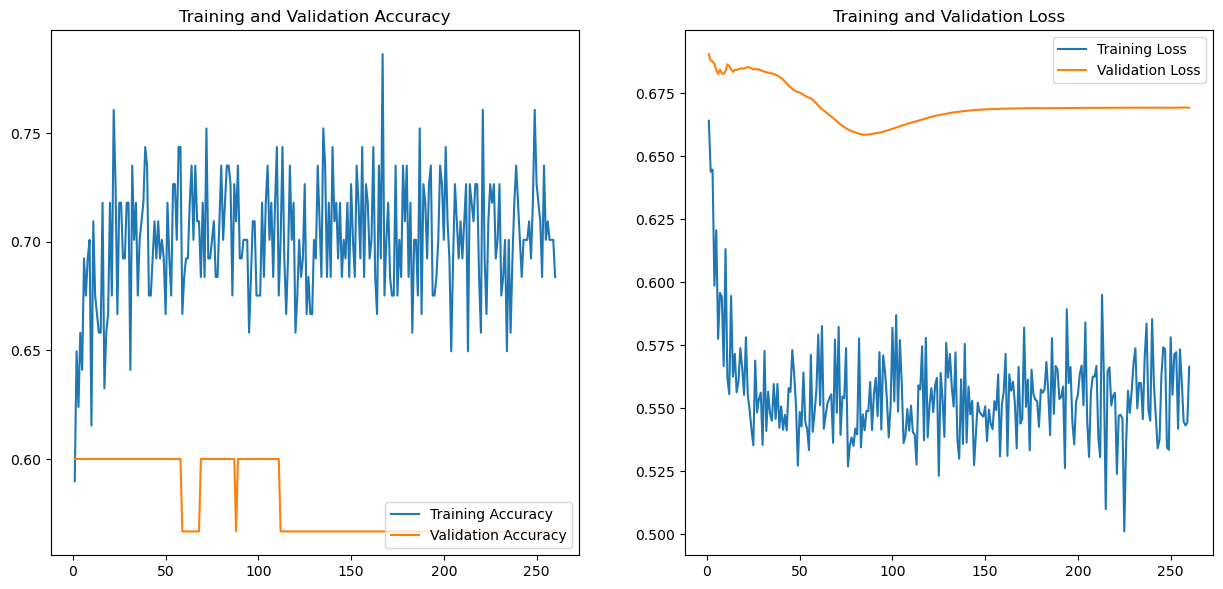

In [12]:
acc = train_o.history['accuracy']
val_acc = train_o.history['val_accuracy']
loss = train_o.history['loss']
val_loss = train_o.history['val_loss']

epochs_range = range(1, len(acc)+1)

#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
def cnn_o_aug(shape=(125, 125, 1)):
    model = Sequential([
        
        Conv2D(6, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.1),
        
        
        Conv2D(8, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(10, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.2),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [14]:
model_o_aug = cnn_o_aug()
model_o_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 125, 125, 6)       60        
                                                                 
 batch_normalization_3 (Batc  (None, 125, 125, 6)      24        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 125, 125, 6)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 6)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 60, 60, 6)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 8)        

In [15]:
learning_rate = 0.001
model_o_aug.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
                rotation_range = 90,
                horizontal_flip = True,
                vertical_flip = True,
                validation_split = 0.20)

aug_train_o = aug.flow(mammo_o_4d, label, batch_size = 30, subset = 'training')
aug_val_o = aug.flow(mammo_o_4d, label, batch_size = 30, subset = 'validation')

In [17]:
batch_size = 42
train_o_aug = model_o_aug.fit(aug_train_o, 
                     batch_size = batch_size,
                     epochs = 260, 
                     verbose = 1,
                     validation_data = aug_val_o,
                     callbacks = [reduce_on_plateau])    

Epoch 1/260
4/4 [==============================] - 3s 545ms/step - loss: 0.9150 - accuracy: 0.4831 - val_loss: 0.6930 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 2s 431ms/step - loss: 0.6907 - accuracy: 0.6441 - val_loss: 0.6949 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 2s 443ms/step - loss: 0.6818 - accuracy: 0.6525 - val_loss: 0.6948 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 2s 455ms/step - loss: 0.5886 - accuracy: 0.7203 - val_loss: 0.6957 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 2s 435ms/step - loss: 0.5765 - accuracy: 0.7119 - val_loss: 0.6995 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 2s 456ms/step - loss: 0.5962 - accuracy: 0.7288 - val_loss: 0.7030 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/260
4/4 [==============================] - 2s 429ms/step - loss: 0.5

Epoch 53/260
4/4 [==============================] - 3s 683ms/step - loss: 0.5375 - accuracy: 0.7627 - val_loss: 0.8607 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 54/260
4/4 [==============================] - 3s 708ms/step - loss: 0.5294 - accuracy: 0.7797 - val_loss: 0.8667 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 55/260
4/4 [==============================] - 3s 668ms/step - loss: 0.5921 - accuracy: 0.7288 - val_loss: 0.8660 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 56/260
4/4 [==============================] - 3s 725ms/step - loss: 0.5312 - accuracy: 0.7542 - val_loss: 0.8686 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 57/260
4/4 [==============================] - 3s 702ms/step - loss: 0.5173 - accuracy: 0.7712 - val_loss: 0.8667 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 58/260
4/4 [==============================] - 3s 707ms/step - loss: 0.5700 - accuracy: 0.7288 - val_loss: 0.8697 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/260
4/4 [============================

4/4 [==============================] - 2s 484ms/step - loss: 0.5601 - accuracy: 0.7627 - val_loss: 0.8599 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 105/260
4/4 [==============================] - 2s 535ms/step - loss: 0.5087 - accuracy: 0.7966 - val_loss: 0.8684 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 106/260
4/4 [==============================] - 2s 578ms/step - loss: 0.5321 - accuracy: 0.7542 - val_loss: 0.8494 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 107/260
4/4 [==============================] - 3s 683ms/step - loss: 0.5632 - accuracy: 0.7373 - val_loss: 0.8633 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 108/260
4/4 [==============================] - 3s 679ms/step - loss: 0.6199 - accuracy: 0.7288 - val_loss: 0.8703 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 109/260
4/4 [==============================] - 3s 691ms/step - loss: 0.5419 - accuracy: 0.7373 - val_loss: 0.8703 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 3

4/4 [==============================] - 3s 683ms/step - loss: 0.5580 - accuracy: 0.7203 - val_loss: 0.8538 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 156/260
4/4 [==============================] - 3s 703ms/step - loss: 0.5334 - accuracy: 0.7458 - val_loss: 0.8466 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 157/260
4/4 [==============================] - 3s 696ms/step - loss: 0.5041 - accuracy: 0.7881 - val_loss: 0.8675 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 158/260
4/4 [==============================] - 3s 677ms/step - loss: 0.5540 - accuracy: 0.7712 - val_loss: 0.8552 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 159/260
4/4 [==============================] - 3s 694ms/step - loss: 0.5078 - accuracy: 0.7627 - val_loss: 0.8652 - val_accuracy: 0.4828 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 3s 728ms/step - loss: 0.5469 - accuracy: 0.7542 - val_loss: 0.8641 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 3

4/4 [==============================] - 2s 434ms/step - loss: 0.5686 - accuracy: 0.7119 - val_loss: 0.8590 - val_accuracy: 0.4828 - lr: 1.0000e-23
Epoch 207/260
4/4 [==============================] - 2s 424ms/step - loss: 0.5208 - accuracy: 0.7712 - val_loss: 0.8460 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 208/260
4/4 [==============================] - 2s 424ms/step - loss: 0.5550 - accuracy: 0.7119 - val_loss: 0.8269 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 209/260
4/4 [==============================] - 2s 420ms/step - loss: 0.5345 - accuracy: 0.7712 - val_loss: 0.8568 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 210/260
4/4 [==============================] - 2s 412ms/step - loss: 0.5471 - accuracy: 0.7797 - val_loss: 0.8577 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 211/260
4/4 [==============================] - 2s 419ms/step - loss: 0.5445 - accuracy: 0.7542 - val_loss: 0.8535 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 212/260
4/4 [==============================] - 2

4/4 [==============================] - 2s 501ms/step - loss: 0.5515 - accuracy: 0.7542 - val_loss: 0.8525 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 258/260
4/4 [==============================] - 2s 506ms/step - loss: 0.5472 - accuracy: 0.7458 - val_loss: 0.8247 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 259/260
4/4 [==============================] - 2s 518ms/step - loss: 0.5297 - accuracy: 0.7458 - val_loss: 0.8654 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 260/260
4/4 [==============================] - 2s 517ms/step - loss: 0.5198 - accuracy: 0.7712 - val_loss: 0.8504 - val_accuracy: 0.5172 - lr: 1.0000e-28


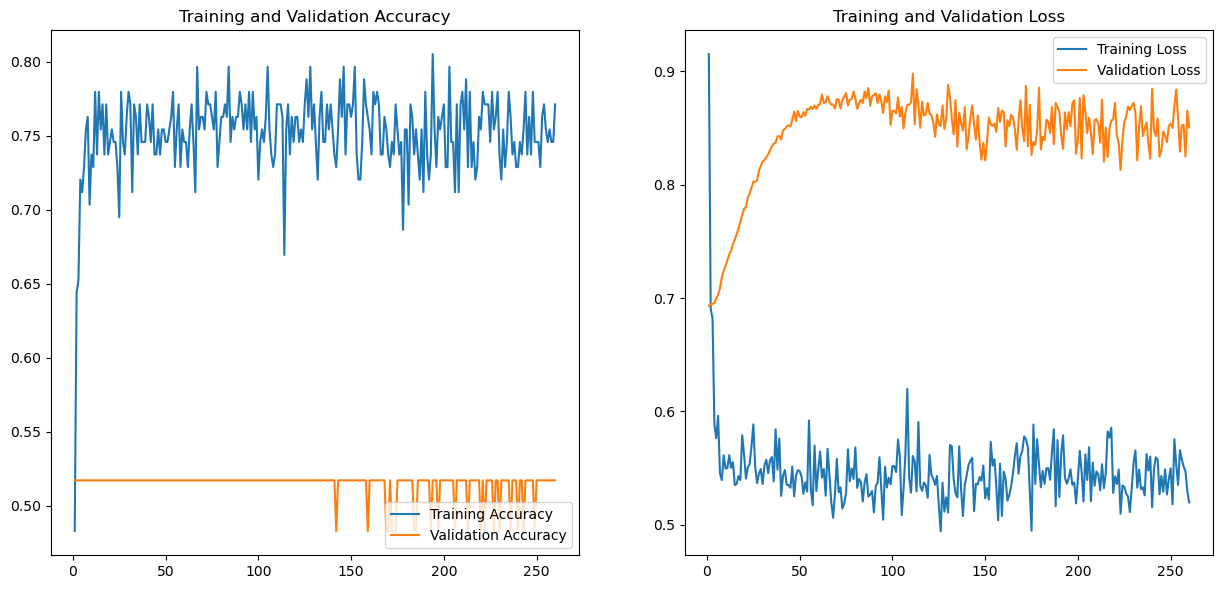

In [18]:
acc = train_o_aug.history['accuracy']
val_acc = train_o_aug.history['val_accuracy']
loss = train_o_aug.history['loss']
val_loss = train_o_aug.history['val_loss']

epochs_range = range(1, len(acc)+1)

#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
acc_o = []
acc_o_aug = []
for i in range(10):
    
    _, val_acc = model_o.evaluate(X_val_o, Y_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_o.append(val_acc)

    _, val_acc = model_o_aug.evaluate(aug_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_o_aug.append(val_acc)

Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.483
Validation accuracy: 0.567
Validation accuracy: 0.483
Validation accuracy: 0.567
Validation accuracy: 0.483
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517


In [20]:
media_o = np.mean(acc_o)
std_o = np.std(acc_o)
print(media_o)
print(std_o)

0.5666666626930237
0.0


In [21]:
media_o_aug = np.mean(acc_o_aug)
std_o_aug = np.std(acc_o_aug)
print(media_o_aug)
print(std_o_aug)

0.5068965345621109
0.01580197997472572


In [22]:
mammo_o_t, mammo_f_t, label_t = [], [], []
data_folder_t = "../test_dataset/"
os.chdir(data_folder_t)
l_t = os.listdir()

FileNotFoundError: [WinError 2] Impossibile trovare il file specificato: '../dataset_test/'

In [ ]:
def create_dataset_t(lista, o_img, f_img, labels):
    #Function calling the Matlab file in order to filter the images.
    for element in lista:
        if "_1_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(1)
        elif "_2_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(0)

In [ ]:
os.chdir("./")
threads = []
chunk = 6

for i in range(5):
    t = thr.Thread(target = create_dataset, args = (l_t[i*chunk : (i+1)*chunk], mammo_o_t, mammo_f_t, label_t))
    threads.append(t)
    t.start()
    
for j in threads:
    j.join()

In [ ]:
eng.quit()

In [ ]:
mammo_o_t = np.asarray(mammo_o_T, dtype = 'float32')/255.
mammo_f_t = np.asarray(mammo_f_t, dtype = 'float32')/255.
label_t = np.asarray(label_T)
mammo_o_4d_t = np.reshape(mammo_o_t, (30, 125, 125, 1))
print(mammo_o_4d_t.shape)
mammo_f_4d_t = np.reshape(mammo_f_t, (30, 64, 64, 1))
print(mammo_f_4d_t.shape)

In [ ]:
if media_o > media_o_aug:
    model_test = model_o()
else:
    model_test = model_o_aug()

In [ ]:
test_loss, test_acc = model.evaluate(mammo_o_4d_t, label_t)
preds_test = model_test.predict(mammo_o_4d_t, verbose=1)
fpr, tpr, _ = roc_curve(label_t, preds_test)
roc_auc = auc(fpr, tpr)

print('\n Test accuracy = %.3f'% (test_acc))
print('\n AUC = %.3f'% (roc_auc))